In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [16]:
train = pd.read_csv("train.csv",parse_dates=["date"])
test = pd.read_csv("test.csv",parse_dates=["date"])

In [17]:
df = pd.concat([train,test],sort=False)

In [18]:
#EDA
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [19]:
df["date"].min(),df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [20]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [21]:
check_df(df)

##################### Shape #####################
(958023, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913023
dtype: int64
##################

In [22]:
df[["store"]].nunique()

store    10
dtype: int64

In [23]:
df[["item"]].nunique()

item    50
dtype: int64

In [24]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [25]:
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36711.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [26]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36711.0  19.854516   19.0   6.788943
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [27]:
#Feature Engineering
def create_date_features(df):
    df["month"]=df.date.dt.month
    df["day_of_month"]=df.date.dt.day
    df["day_of_year"]=df.date.dt.dayofyear
    df["week_of_year"]=df.date.dt.weekofyear
    df["day_of_week"]=df.date.dt.dayofweek
    df["year"]=df.date.dt.year
    df["is_wknd"]=df.date.dt.weekday//4
    df["is_month_start"]=df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [29]:
df = create_date_features(df)

In [30]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [31]:
df.groupby(["store","item","month"]).agg({"sales":["sum","median","mean","std"]})

sales                             
                      sum median       mean        std
store item month                                      
1     1    1       2368.0   13.0  13.303371   4.389007
           2       2063.0   14.0  14.631206   4.668146
           3       2728.0   17.0  17.600000   4.545013
           4       3118.0   20.0  20.786667   4.894301
           5       3448.0   22.0  22.245161   6.564705
...                   ...    ...        ...        ...
10    50   8      13108.0   85.0  84.567742  15.676527
           9      11831.0   79.0  78.873333  15.207423
           10     11322.0   72.0  73.045161  14.209171
           11     11549.0   77.0  76.993333  16.253651
           12      8724.0   56.0  56.283871  11.782529

[6000 rows x 4 columns]

In [33]:
#Random Noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6,size=(len(dataframe),))

In [35]:
#Log-Shifted Features
df.sort_values(by=["store","item","date"],axis=0,inplace=True)

In [37]:
df.groupby(["store", "item"])['sales'].head()

0         13.0
24        13.0
1         11.0
25        11.0
2         14.0
          ... 
911197    33.0
911198    37.0
911199    46.0
911200    51.0
911201    41.0
Name: sales, Length: 2500, dtype: float64

In [40]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [41]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [42]:
check_df(df)

##################### Shape #####################
(958023, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int32
is_month_end               int32
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
         date  store  item  sale

In [44]:
#Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [45]:
df = roll_mean_features(df,[365,546])

In [46]:
#Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [47]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [48]:
df = ewm_features(df, alphas, lags)

In [49]:
check_df(df)

##################### Shape #####################
(958023, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
         date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sal

date                               0
store                              0
item                               0
sales                          45000
id                            913023
                               ...  
sales_ewm_alpha_05_lag_180     90000
sales_ewm_alpha_05_lag_270    135000
sales_ewm_alpha_05_lag_365    182500
sales_ewm_alpha_05_lag_546    273000
sales_ewm_alpha_05_lag_728    364000
Length: 71, dtype: int64
##################### Quantiles #####################
                            0.00         0.05          0.50          0.95          0.99          1.00
store                        1.0     1.000000      5.000000     10.000000     10.000000     10.000000
item                         1.0     3.000000     25.000000     48.000000     50.000000     50.000000
sales                        0.0    16.000000     47.000000    107.000000    135.000000    231.000000
id                           0.0  2249.950000  22499.500000  42749.050000  44549.010000  44999.000000
mont

In [50]:
#One Hot Encoding
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

In [51]:
check_df(df)

##################### Shape #####################
(958023, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
         date  sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_

date                 0
sales            45000
id              913023
day_of_month         0
day_of_year          0
                 ...  
month_8              0
month_9              0
month_10             0
month_11             0
month_12             0
Length: 146, dtype: int64
##################### Quantiles #####################
              0.00     0.05     0.50      0.95      0.99     1.00
sales          0.0    16.00     47.0    107.00    135.00    231.0
id             0.0  2249.95  22499.5  42749.05  44549.01  44999.0
day_of_month   1.0     2.00     16.0     29.00     31.00     31.0
day_of_year    1.0    16.00    174.0    347.00    362.00    366.0
week_of_year   1.0     3.00     25.0     50.00     52.00     53.0
...            ...      ...      ...       ...       ...      ...
month_8        0.0     0.00      0.0      1.00      1.00      1.0
month_9        0.0     0.00      0.0      1.00      1.00      1.0
month_10       0.0     0.00      0.0      1.00      1.00      1.0
month_1

In [52]:
#converting sales to log(1+sales)
df['sales'] = np.log1p(df["sales"].values)

In [53]:
#Model

#Custom Cost Function(SMAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [54]:
# Time-Based Validation Sets

train
test

# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730523,), (730523, 142), (45000,), (45000, 142))

In [55]:
#LightGBM
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [56]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.444611 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513369	training's SMAPE: 17.5905	valid_1's l2: 0.0532582	valid_1's SMAPE: 17.4866
[200]	training's l2: 0.0352007	training's SMAPE: 14.5636	valid_1's l2: 0.0370448	valid_1's SMAPE: 14.884
[300]	training's l2: 0.0323994	training's SMAPE: 14.0014	valid_1's l2: 0.0340945	valid_1's SMAPE: 14.42
[400]	training's l2: 0.0313524	training's SMAPE: 13.7953	valid_1's l2: 0.0332145	valid_1's SMAPE: 14.2646
[500]	training's l2: 0.0306721	training's SMAPE: 13.6622	valid_1's l2: 0.0326832	valid_1's SMAPE: 14.1525
[600]	training's l2: 0.0302221	training's SMAPE: 13.5679	valid_1's l2: 0.0321913	valid_1's SMAPE: 14.0363
[700]	training's l2: 0.0298842	training's SMAPE: 13.5001	valid_1's l2: 0.0318627	valid_1's SMAPE: 13.9598
[800]	training's l2: 0.0296066	tra

In [57]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.826716067981128

In [58]:
#Feature Importances
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

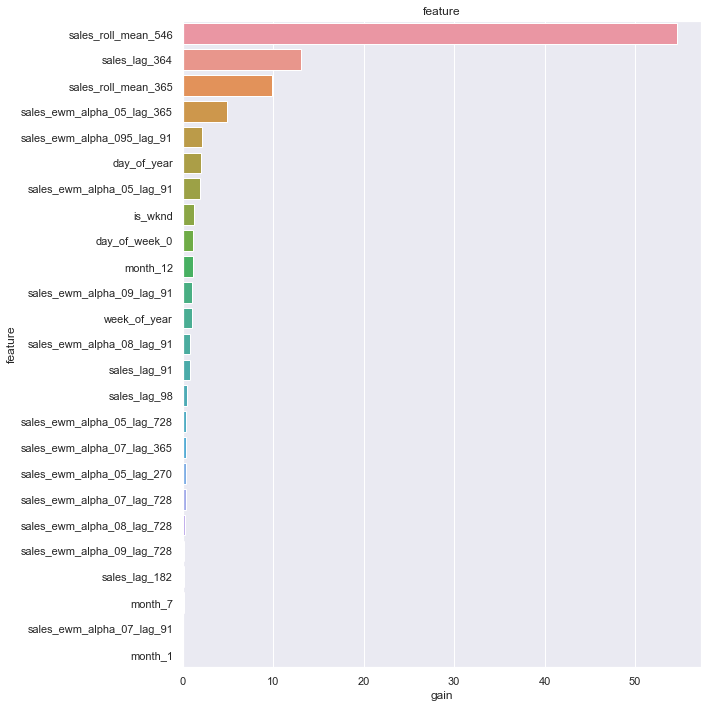

,feature,split,gain
17,sales_roll_mean_546,947,54.582830
13,sales_lag_364,1251,13.090084
16,sales_roll_mean_365,604,9.863313
60,sales_ewm_alpha_05_lag_365,367,4.890700
18,sales_ewm_alpha_095_lag_91,91,2.183008
...,...,...,...
79,item_7,0,0.000000
111,item_39,0,0.000000
78,item_6,0,0.000000
115,item_43,0,0.000000


In [59]:
plot_lgb_importances(model,num=200,plot=True)

In [60]:
# Final Model

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.533575 seconds.
You can set `force_col_wise=true` to remove the overhead.
